# Run HBV model with ERA5 and CMIP forcing for Climate Change Impact Analyses

In this notebook we run your the HBV model using both ERA5 forcing data as well as CMIP data (from the previous notebook). For the historical periods the model run outputs are compared to GRDC observation data. Using this, a function is derived to bias correct the output of the model runs forced with the CMIP data. Finally, an ensemble of model runs is done for future climate and this is bias corrected.


In [1]:
# eWaterCycle dependencies
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis

# note that the model is a plugin which lives in its own repository.
# if you have not installed this model yet, you can do so by running
# !pip install ewatercycle-hbv
from ewatercycle.models import HBVLocal

# other dependencies
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import json

/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


In the cell below all the choices for the analyses are made. Note the note for the Climate Model ('MPI-ESM1-2-LR') and the specific experiment ('ssp585')

In [2]:
#shapefile that describes the basin we want to study.
path = Path.cwd()
forcing_path = path / "Forcing"
shapeFile = Path("/home/rhut/metaFiles") / "Rhine.shp"


#GRDC station ID for the observation station
grdc_station_id = "6335020"  # GRDC station ID
basin_name = "Rhine"

#location to saved forcing results from previous notebook
ERA5forcingLocation = forcing_path / ("GRDCStation" + grdc_station_id + "ERA5") / "work" / "diagnostic" / "script"
CMIPHistoricalforcingLocation = forcing_path / ("GRDCStation" + grdc_station_id + "CMIPHistorical") / "work" / "diagnostic" / "script"

# details needed for the prediction ensemble
CMIPPredictionforcingLocation = forcing_path / ("GRDCStation" + grdc_station_id + "CMIPPrediction")

# selection of climate model(s) and experiments. Confusingly, climate models are called
# datasets in ESGF/CMIP/ESMValTool jargon
dataset = 'MPI-ESM1-2-LR'
exp = 'ssp585'

# location where the json input files are located (from notebook 0)
config_file_location = Path.cwd() / "configFiles"


Forcing was created in the previous notebook and loaded gere

In [3]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(ERA5forcingLocation)
CMIPHistorical_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(CMIPHistoricalforcingLocation)
print(ERA5_forcing)
print(CMIPHistorical_forcing)

LumpedMakkinkForcing(
    start_time='2000-01-01T00:00:00Z',
    end_time='2005-12-31T00:00:00Z',
    directory=PosixPath('/home/rhut/repos/ewatercycle-climatechangeimpact/Forcing/GRDCStation6335020ERA5/work/diagn
ostic/script'),
    shape=PosixPath('/home/rhut/repos/ewatercycle-climatechangeimpact/Forcing/GRDCStation6335020ERA5/work/diagnosti
c/script/Rhine.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2000-2005.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2000-2005.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2000-2005.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

LumpedMakkinkForcing(
    start_time='2000-01-01T00:00:00Z',
    end_time='2005-12-31T00:00:00Z',
    directory=PosixPath('/home/rhut/repos/ewatercycle-climatechangeimpact/Forcing/GRDCStation6335020CMIPHistorical/
work/diagnostic/script'),
    shape=PosixPath('/home/rhut/repos/ewatercycle-climatechangeimpact/Forcing/GRDCStation6335020CMIPHistorical/work
/diagnostic/script/Rhine.shp'),
    filenames={
        'pr': 'CMIP6_MPI-ESM1-2-LR_day_historical_r3i1p1f1_pr_gn_2000-2005.nc',
        'tas': 'CMIP6_MPI-ESM1-2-LR_day_historical_r3i1p1f1_tas_gn_2000-2005.nc',
        'rsds': 'CMIP6_MPI-ESM1-2-LR_day_historical_r3i1p1f1_rsds_gn_2000-2005.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

Now we have the forcing data available we can prepare the configuration files just as in the first notebook. Note that we are using the parameters calibrated in the second notebook.

In [4]:
##              Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]


In [5]:
#from step 2 notebook
par_0 = np.loadtxt('calibration.csv', delimiter = ",")
print(par_0)

[5.47825688e+00 6.80794043e-01 4.91050067e+02 2.44234273e+00
 1.63259937e-01 3.81204705e+00 8.87461454e-02 2.63979061e-03
 4.41831188e+00]

For the comparison of historical model runs forced with the CMIP model versus ERA5, we create model objects and initialize them.

In [6]:
ERA5model = HBVLocal(forcing=ERA5_forcing)
CMIPHistoricalmodel = HBVLocal(forcing=CMIPHistorical_forcing)

In [7]:
ERA5_config_file, _ = ERA5model.setup(
                            parameters=','.join([str(p) for p in par_0]),
                            initial_storage=','.join([str(s) for s in s_0]),
                            cfg_dir = "configFiles/hbv_ERA5",
                               )

In [8]:
CMIPHistorical_config_file, _ = CMIPHistoricalmodel.setup(
                            parameters=','.join([str(p) for p in par_0]),
                            initial_storage=','.join([str(s) for s in s_0]),
                            cfg_dir = "configFiles/hbv_CMIPHistorical",
                               )

In [9]:
ERA5model.initialize(ERA5_config_file)
CMIPHistoricalmodel.initialize(CMIPHistorical_config_file)

/home/rhut/.local/lib/python3.10/site-packages/HBV/HBV_bmi.py:54: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
/home/rhut/.local/lib/python3.10/site-packages/HBV/HBV_bmi.py:54: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values

In the cell below those two models are run for the historical period

In [10]:
Q_m_ERA5 = []
Q_m_CMIPHistorical = []
time = []
while ERA5model.time < ERA5model.end_time:
    ERA5model.update()
    CMIPHistoricalmodel.update()
    
    discharge_this_timestep = ERA5model.get_value("Q")
    Q_m_ERA5.append(discharge_this_timestep[0])
    
    discharge_this_timestep = CMIPHistoricalmodel.get_value("Q")
    Q_m_CMIPHistorical.append(discharge_this_timestep[0])
    
    time.append(pd.Timestamp(ERA5model.time_as_datetime.date()))

We can plot the output discharge directly using matplotlib

Text(0.5, 0, 'Time')

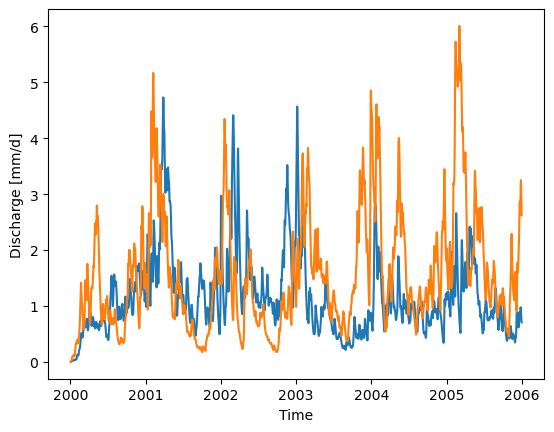

In [11]:
import matplotlib.pyplot as plt
plt.plot(time, Q_m_ERA5)
plt.plot(time, Q_m_CMIPHistorical)

plt.ylabel(f"Discharge [{ERA5model.bmi.get_var_units('Q')}]")
plt.xlabel("Time")

## analyse results
We can also use the ```hydrograph``` function from eWaterCycle. This will make a hydrograph that compares model output to observations. For this we need to load observations and make sure that the observations and model output are in the same units. Observations typically are in m3/s. 

Note that the unit of discharge from this model is in mm/d. Conversion to m3/s requires the area of the catchment.

In [12]:
shapeObject = shapereader.Reader(shapeFile.absolute())
record = next(shapeObject.records())
shape_area = record.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", shape_area)

The catchment area is: 163122500000.0

The hydrograph function requires dataFrames, so we put the discharge in a dataFrame and transform it to m3 per second 

In [13]:
discharge_dataframe = pd.DataFrame({'model output ERA5 forcing': Q_m_ERA5 ,
                                    'model output CMIP Historical forcing': Q_m_CMIPHistorical }
                                   , index=pd.to_datetime(time))
print(discharge_dataframe)

model output ERA5 forcing  model output CMIP Historical forcing
2000-01-02                   0.001661                              0.001661
2000-01-03                   0.006650                              0.007079
2000-01-04                   0.011659                              0.014786
2000-01-05                   0.013627                              0.023411
2000-01-06                   0.014688                              0.033766
...                               ...                                   ...
2005-12-27                   0.955829                              3.237973
2005-12-28                   0.895336                              3.249156
2005-12-29                   0.829540                              3.093509
2005-12-30                   0.765132                              2.858820
2005-12-31                   0.706442                              2.621525

[2191 rows x 2 columns]

In [14]:
discharge_dataframe['model output ERA5 forcing'] = discharge_dataframe['model output ERA5 forcing'] * shape_area / (1000 * 86400)
discharge_dataframe['model output CMIP Historical forcing'] = discharge_dataframe['model output CMIP Historical forcing'] * shape_area / (1000 * 86400)

The observation data is loaded using ```the get_grdc_data()``` function build into eWaterCycle. The observation data and discharge data are combined together into one dataFrame. Note that we re-index the discharge data to make sure they are at the same timestamp.

In [15]:

observations_df, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time=ERA5_forcing.start_time,
    end_time=ERA5_forcing.end_time,
)
grdc_obs = observations_df.rename(columns={"streamflow": "Observations from GRDC"})
grdc_lon = metadata["grdc_longitude_in_arc_degree"]
grdc_lat = metadata["grdc_latitude_in_arc_degree"]

In [16]:
hydro_data = pd.concat([discharge_dataframe.reindex(grdc_obs.index, method = 'ffill'), grdc_obs], axis=1)
hydro_data

,model output ERA5 forcing,model output CMIP Historical forcing,Observations from GRDC
time,,,
2000-01-01,NaN,NaN,6010.0
2000-01-02,3.135642,3.135647,5330.0
2000-01-03,12.554967,13.364911,4700.0
2000-01-04,22.011425,27.916473,4260.0
2000-01-05,25.727655,44.199684,3980.0
...,...,...,...
2005-12-27,1804.597866,6113.266845,1530.0
2005-12-28,1690.386636,6134.379456,1500.0
2005-12-29,1566.165283,5840.519116,1470.0


Finally plot the hydrograph. It is remarkabe to see how well a simple model like HBV, is already able to predict discharge in the Rhine. Since the CMIP model is not constrained in any way by (athmospheric) observations, the timing of the events will not match, however, ideally, the distribution of calculated discharge matches those from the model output forced with ERA5 data.

/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [0] contained NaN values and the row(s) have been removed (Rows are zero indexed).


(<Figure size 1000x1000 with 2 Axes>,
 (<Axes: title={'center': 'Hydrograph'}, xlabel='time', ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <Axes: >))

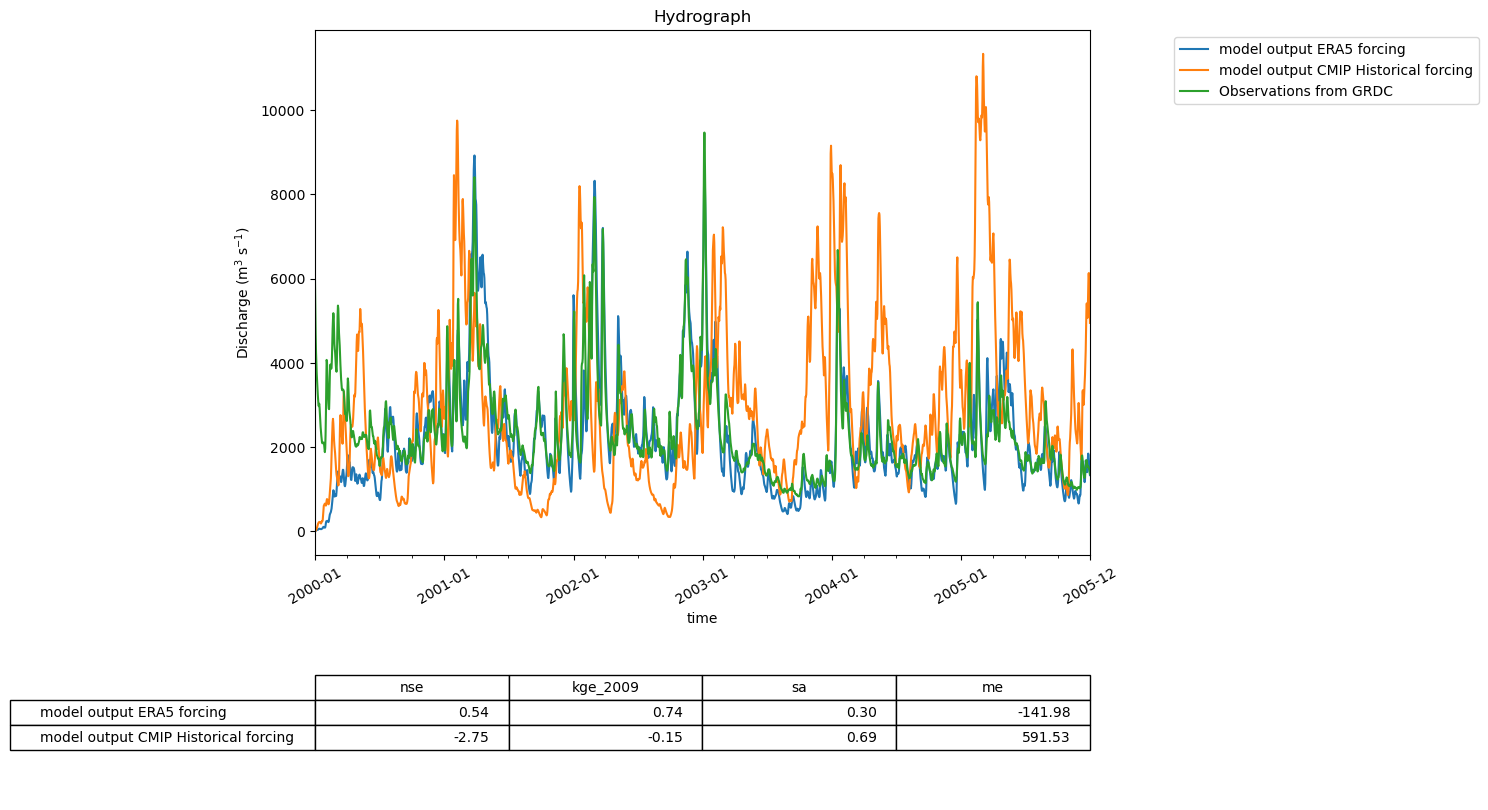

In [17]:
# Plot hydrograph and show metrics
ewatercycle.analysis.hydrograph(hydro_data, reference='Observations from GRDC', filename = 'experiment_hydrograph.png')

It is good practice to remove a model object when done using ```.finalize()```. For small models like this, it doesn't matter too much, but larger models that run in containers keep using resources when not ```finalized```.

In [18]:
ERA5model.finalize()
CMIPHistoricalmodel.finalize()

# CDF comparison of ERA5 and CMIP model outputs
by sorting the output in order of decreasing discharge, we can easily make a cummalative distribution. By taking the difference of these functions we derive a (very simple) bias correction function that can later be used to bias-correct the future model output when forced with CMIP projections 

In [30]:
hydro_cdf = pd.DataFrame({'model output ERA5 cdf': hydro_data['model output ERA5 forcing'].sort_values().values,
                         'model output CMIP Historical cdf': hydro_data['model output CMIP Historical forcing'].sort_values().values,
                         'Observations from GRDC cdf': hydro_data['Observations from GRDC'].sort_values().values
                         }
                         , index=np.linspace(0.,1.,len(hydro_data)))

In [31]:
print(hydro_cdf)

model output ERA5 cdf  model output CMIP Historical cdf  \
0.000000               3.135642                          3.135647   
0.000456              12.554967                         13.364911   
0.000913              22.011425                         27.916473   
0.001369              25.727655                         44.199684   
0.001826              27.731691                         63.749405   
...                         ...                               ...   
0.998174            8619.591788                      10807.921547   
0.998631            8737.273831                      10925.331103   
0.999087            8823.516753                      11033.013965   
0.999544            8926.033668                      11339.439292   
1.000000                    NaN                               NaN   

          Observations from GRDC cdf  
0.000000                       830.0  
0.000456                       831.0  
0.000913                       834.0  
0.001369                       837.0  
0.001826                       841.0  
...                              ...  
0.998174                      8410.0  
0.998631                      8440.0  
0.999087                      9070.0  
0.999544                      9080.0  
1.000000                      9470.0  

[2192 rows x 3 columns]

Text(0, 0.5, 'discharge m3/s')

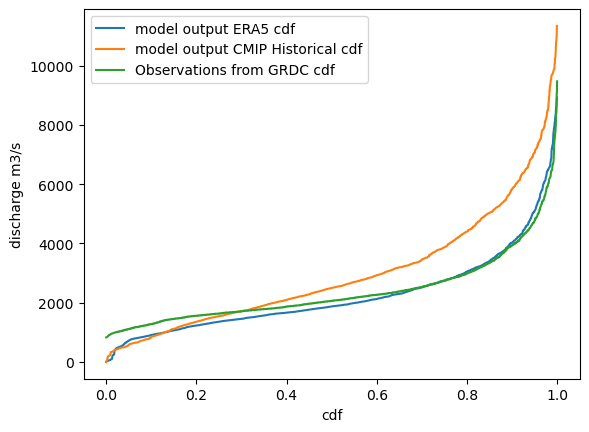

In [32]:
hydro_cdf.plot()
plt.xlabel('cdf')
plt.ylabel('discharge m3/s')

We clearly see that for the higher flows the model forced with CMIP data gives far greater discharge output than the model calibrated with ERA5.

Below we derive a bias correction by taking the difference between the CMIP forced output and the observations. 

In [33]:
hydro_cdf['CMIP to Observations correction'] = hydro_cdf['Observations from GRDC cdf'] - hydro_cdf['model output CMIP Historical cdf']
                                                

<Axes: >

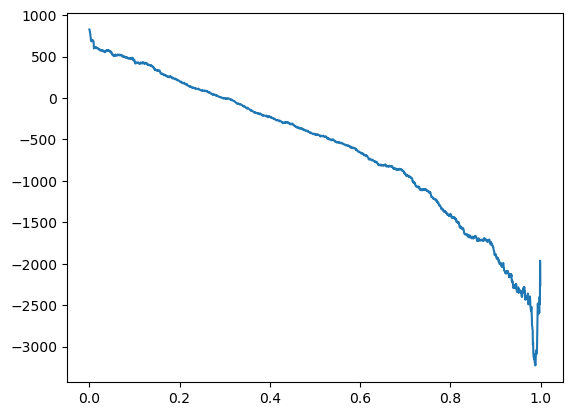

In [34]:
#hydro_cdf = hydro_cdf.set_index(['model output CMIP Historical cdf'])
hydro_cdf['CMIP to Observations correction'].plot()

# Run ensemble of CMIP projections for climate impace
Below we first run all the ensemble members using the forcing generated in the previous notebooks. We collect all the output in the ensemble_output dict.

In [24]:
#todo, make saved ensemble codes nice path thingies
json_file = "datasets_" + dataset + "_" + exp + ".json"
with (open(config_file_location / json_file, 'r')) as the_file:
    ensembles = json.load(the_file)


In [25]:
ensemble = {}
ensemble_output = {}

for ensembleCode in ensembles:

    ensembleForcingLocation = CMIPPredictionforcingLocation / dataset / ensembleCode / "work" / "diagnostic" / "script"

    ensembleForcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(ensembleForcingLocation)

    ensemble[ensembleCode] = HBVLocal(forcing=ensembleForcing)
    config_file, _ = ensemble[ensembleCode].setup(
                            parameters = ','.join([str(p) for p in par_0]),
                            initial_storage=','.join([str(s) for s in s_0]),
                            cfg_dir = "configFiles/hbv_ensembleMember_" + ensembleCode,
                               )
    ensemble[ensembleCode].initialize(config_file)
    
    Q_m_ensemble_member = []
    time = []
    while ensemble[ensembleCode].time < ensemble[ensembleCode].end_time:
        ensemble[ensembleCode].update()
        
        discharge_this_timestep = ensemble[ensembleCode].get_value("Q")
        Q_m_ensemble_member.append(discharge_this_timestep[0])
        
        time.append(pd.Timestamp(ensemble[ensembleCode].time_as_datetime.date()))
        
    ensemble_output[ensembleCode] = Q_m_ensemble_member

    ensemble[ensembleCode].finalize()

/home/rhut/.local/lib/python3.10/site-packages/HBV/HBV_bmi.py:54: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
/home/rhut/.local/lib/python3.10/site-packages/HBV/HBV_bmi.py:54: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values

# analyse output: climate change impact
First we create a dataframe that holds all the ensemble output and plot it to do a visual check 

In [26]:
ensemble_output_dataframe = pd.DataFrame(ensemble_output, index = time)
for ensembleCode in ensembles:
    ensemble_output_dataframe[ensembleCode] = ensemble_output_dataframe[ensembleCode] * shape_area / (1000 * 86400)
    


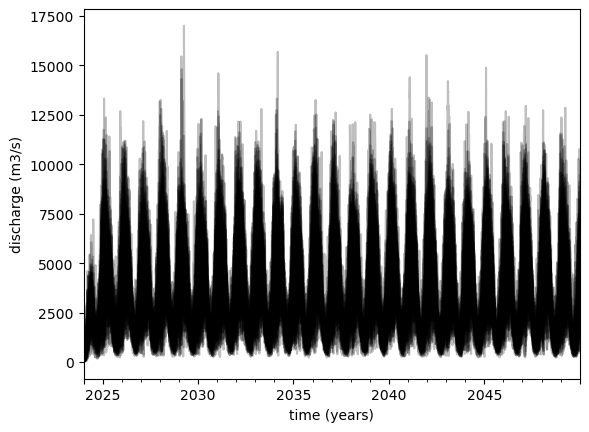

In [53]:
ensemble_output_dataframe.plot(legend = None, color = 'black', alpha = 0.25)
plt.xlabel('time (years)')
plt.ylabel('discharge (m3/s)')
plt.savefig('test.png')

We create a sorted dataset to compare the cdf of the CMIP output to the original historical run

In [36]:
sorted_ensemble_output_dataframe = pd.DataFrame()

for col in ensemble_output_dataframe:
    sorted_ensemble_output_dataframe[col] = ensemble_output_dataframe[col].sort_values(ignore_index=True).values

sorted_ensemble_output_dataframe.index = np.linspace(0.,1.,len(ensemble_output_dataframe))

sorted_ensemble_output_dataframe['Historical'] = hydro_cdf['model output CMIP Historical cdf'].reindex(sorted_ensemble_output_dataframe.index, method = 'ffill')





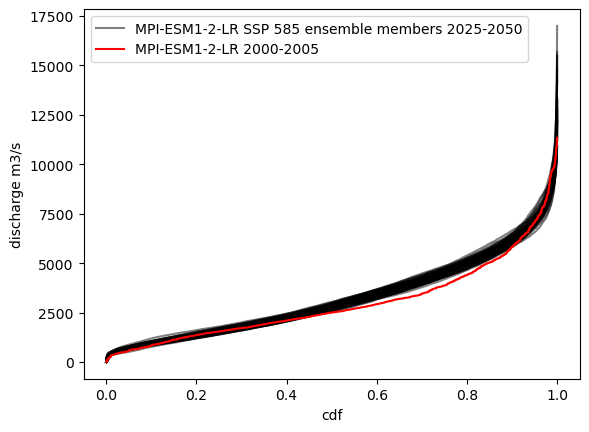

In [51]:
ax = sorted_ensemble_output_dataframe.iloc[:, :-1].plot(color='black', alpha=0.5, legend=False)
sorted_ensemble_output_dataframe.iloc[:, -1].plot(color='red', ax=ax, legend=False)
handles = [plt.Line2D([0], [0], color='black', alpha=0.5), plt.Line2D([0], [0], color='red')]
labels = ['MPI-ESM1-2-LR SSP 585 ensemble members 2025-2050', 'MPI-ESM1-2-LR 2000-2005']
ax.legend(handles, labels)
plt.xlabel('cdf')
plt.ylabel('discharge m3/s')
plt.show()
#used ChatGPT4o for generating the code to plot this ensemble in this way.

Finally, we use the correction factor to bias correct the climate projections and calculate the expected percentage change in discharge compared to current (2000-2005) period.

In [66]:
corrected_ensemble_output_dataframe = pd.DataFrame()
for col in ensemble_output_dataframe:
    
    corrected_ensemble_output_dataframe[col] = 100 * (sorted_ensemble_output_dataframe[col].reindex(hydro_cdf.index, method = 'ffill') + hydro_cdf['CMIP to Observations correction'] - hydro_cdf['Observations from GRDC cdf']) / hydro_cdf['Observations from GRDC cdf']
    
corrected_ensemble_output_dataframe.index = hydro_cdf['Observations from GRDC cdf']

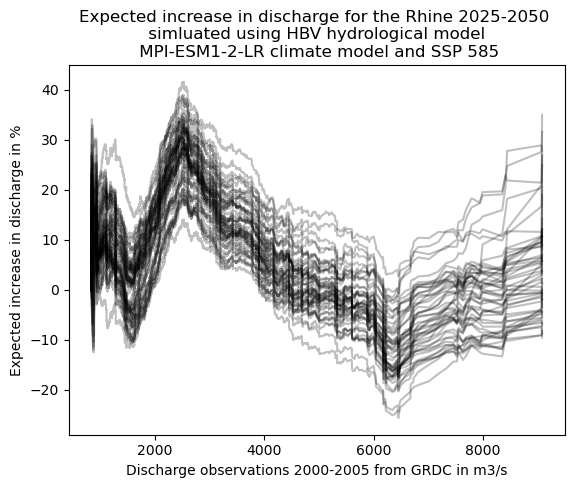

In [77]:
corrected_ensemble_output_dataframe.plot(legend = None, color = 'black', alpha = 0.25)
plt.xlabel('Discharge observations 2000-2005 from GRDC in m3/s')
plt.ylabel('Expected increase in discharge in %')
plt.title('Expected increase in discharge for the Rhine 2025-2050 \n simluated using HBV hydrological model \n MPI-ESM1-2-LR climate model and SSP 585')
plt.show()